# Improving performance of electron-specific ML algorithms with dimensionally reduced "split chi2" track-trigger variables

Wow, that was a long one.

## Abstract

For the relevant background on machine learning for the track-trigger, read this repository's [README](README.md).

This study had two goals:

- First, determine whether the introduction of new track properties, namely **chi2rphi** and **chi2rz**, improve the performance of machine learning algorithms dedicated to discriminating between primary-interaction electron tracks and fake tracks.  
*This was found to be the case, but not as much as we'd hoped*: the area under the ROC curves for the models increased by 2-3%.

- Second, determine whether we need fancy machine learning at all, or whether the performance of new **chi2rz** cuts on the maybe-electrons performed better.  
*Ignoring computational time, the models performed significantly better*. The question of computational time is ignored in this study.

- An auxilliary goal to these two primary goals was to ensure that the discriminators (models and cuts) used didn't discriminate against things they didn't intend to, such as only select tracks in certain pT ranges.  
*Currently, I'm not sure.*

Future studies in this line of thought should optimize model hyperparameters and make use of the tracklet seed variable for tracks.

## Why are these new variables useful for electron identification?

### Well, what are they?

The chi2 variables here represent how well the stubs of a track line up with those of an ideal track, given the track's parameters. As you might guess from the name, chi2rphi is the component of chi2 in the r-phi plane of the detector, while chi2rz is the component in the r-z plane. More information about these variables can be found in [the slideshow presentation in this repository](split_chi2.pdf).

### And what about the electrons?

As electrons have low mass, their interactions with the detector will bend their tracks. This causes their stubs to have a high chi2, and will often cause electrons to be mistaken for fake tracks. However, this "bouncing" only occurs in the r-phi plane, meaning that chi2rz-based predictions are much less likely to mistake electrons for fake tracks. So, let's see what machine learning has to say about that.

## Methods

The Monte-Carlo sample set used for this is:
- a Z to electron-positron sample
- with around 9000 events
- with a pileup of 200
- run on the D49 detector geometry
    - with T14 tracker geometry.

All of the code here is run using the `ntupledicts` package, which can be found [here](https://github.com/cqpancoast/ntupledicts), along with a simple tutorial that covers all code used.

---

In [1]:
from ntupledicts import load as ndload
from ntupledicts import operations as ndops
from ntupledicts import analyze as ndanl
from ntupledicts.operations import select as sel
from ntupledicts.ml import data as ndmldata
from ntupledicts.ml import predict as ndmlpred
from ntupledicts.ml import models as ndmlmodels

## Data Acquisition

Grab tracks from stored ntuples, perform cuts, process into datasets.
Take all electron tracks from the primary interaction and an equal number of fake tracks.

In [2]:
# List the root files we want ntuples from (just one this time)
input_files = ["eventsets/ZEE_PU200_D49_full.root"]
    
# What track properties do we want available to play with?
# We can select which ones we want our models to train on later
track_properties = ["pt", "eta", "z0", "nstub",
                        "hitpattern", "chi2", "bendchi2", "chi2rphi", "chi2rz"]
properties_by_track_type = {"trk": track_properties + ["matchtp_pdgid", "genuine"],
                            "matchtrk": track_properties, 
                            "tp": ["pdgid", "eventid"]}

# Create ntuple dict from input files
ntuple_dict = ndload.root_files_to_ntuple_dict(input_files, properties_by_track_type)

### Apply Cuts

We want electron matchtrks from the primary interaction and an equal number of fake trks. This may take a while if the dataset is large. Thankfully, this is a jupyter notebook.

In [3]:
# Set randomness seed to use throughout study
random_seed = 42

# Get electron matchtrks from the primary interaction, fake trks
# Note that cutting on tp's also cuts on matchtrks
el_sel = sel([sel(11), sel(-11)])
ntuple_dict = ndops.cut_ntuple_dict(ntuple_dict, {"tp": {"pdgid": el_sel, "eventid": sel(0)},
                                            "matchtrk": {"hitpattern": sel([sel(-999)], invert=True)},
                                                 "trk": {"genuine": sel(0)}})
matchtrk_els = ntuple_dict["matchtrk"]
matchtrk_els["genuine"] = [1 for _ in range(ndops.track_prop_dict_length(matchtrk_els))]
    # All matchtrks are genuine
trk_not_gens = ntuple_dict["trk"]
trk_not_gens = ndops.reduce_track_prop_dict(trk_not_gens, ndops.track_prop_dict_length(matchtrk_els),
                                            seed=random_seed)

# Cut down the number of not genuine tracks to the number of electrons
print("Number of primary interaction electron tracks: {}".format(ndops.track_prop_dict_length(matchtrk_els)))
print("Cut down number of not genuine tracks: {}".format(ndops.track_prop_dict_length(trk_not_gens)))

# Now, add them together and shuffle the dict.
els_and_fakes_tpd = ndops.shuffle_track_prop_dict(
                        ndops.add_track_prop_dicts([matchtrk_els, trk_not_gens]),
                        seed=random_seed)

Number of primary interaction electron tracks: 11463
Cut down number of not genuine tracks: 11463


/Users/caseypancoast/Code/CERN/ml-stuff/ntupledicts/src/ntupledicts/operations.py:61: UserWarning: Track property dicts have differing value lists. Will add only properties in common: {'genuine', 'chi2rz', 'nstub', 'pt', 'hitpattern', 'chi2', 'eta', 'bendchi2', 'z0', 'chi2rphi'}
  warn("Track property dicts have differing value lists. "


Don't worry: **a `UserWarning` is expected here**, as the track properties dict `trk_not_gens` has a property "matchtp_pdgid" that `matchtrk_els` doesn't have. The track property dict resulting from the sum will not have that property.

### Add Stub-Based Track Properties

Use hitpattern and eta to determine how many missing 2S and PS stubs there are for each track. (Note that this is post-cuts — if we want to place cuts on these, we'll move this cell before the cut application cell.)

In [4]:
# Count layers meeting these conditions for each track. (see ntupledicts.analyze for documentation)
missing_2S_layer = lambda expected, hit, ps: not ps and expected and not hit
missing_PS_layer = lambda expected, hit, ps: ps and expected and not hit

els_and_fakes_tpd["missing2S"] = ndanl.create_stub_info_list(els_and_fakes_tpd,
        ndanl.basic_process_stub_info(missing_2S_layer))
els_and_fakes_tpd["missingPS"] = ndanl.create_stub_info_list(els_and_fakes_tpd,
        ndanl.basic_process_stub_info(missing_PS_layer))

### Process into Datasets

Process the ntuple dict above into `TrackPropertiesDataset`s.

In [5]:
common_track_props = ["eta", "z0", "bendchi2", "nstub", "missingPS"]  
    # Track properties that all sets of models will use.
label_property = "genuine"  # What property are we trying to predict?
split_list = [.7, .2, .1]   # How many datasets should we create, and with what relative sizes?
train_ds, eval_ds, test_ds = ndmldata.TrackPropertiesDataset(els_and_fakes_tpd,
                                                             label_property).split(split_list)

## Making Models

Build two neural networks and two gradient boosted decision trees, train one of each on data containing the split chi2 variables and one of each on data with the non-split chi2. Also define two sets of predictive cuts to compare our models against.

Because chi2rz is the variable good at identifying electrons, and chi2rphi was the component of the original chi2 that confused those and fakes, chi2rphi has been left out of the training for the split chi2 model sets.

### Defining Model Sets

We'll create two sets of models — one with the common properties and chi2, and the other with the common properties and chi2rz.
However, to include another set of models, simply add a list of track properties to `model_sets_dict`.

*Note that pT is not a training variable for either of these sets* — including pT increases model performance by a bit, but it ends up discriminating heavily against lower tracks in a way that we don't want.

In [6]:
# A map from the names of the model sets to the properties they have in addition to the common properties.
model_sets_dict = {"chi2": ["chi2"], "split_chi2": ["chi2rz"]}
model_set_names = list(model_sets_dict.keys())

In [7]:
# Make our models and predictive cuts
NNs = {}
GBDTs = {}
for model_set_name, model_set_track_props in model_sets_dict.items():
    
    # Set dataset active properties to common and set-specific properties
    for ds in [train_ds, eval_ds, test_ds]:
        ds.set_active_data_properties(common_track_props + model_set_track_props)
        
    print("Now training models of set '{}', using set-specific properties {}."
          .format(model_set_name, model_set_track_props))
    
    NNs[model_set_name] = ndmlmodels.make_neuralnet(train_ds,
                                                   eval_dataset=eval_ds,
                                                   hidden_layers=[15, 8],
                                                   epochs=3)
    GBDTs[model_set_name] = ndmlmodels.make_gbdt(train_ds)

Now training models of set 'chi2', using set-specific properties ['chi2'].
Epoch 1/3
5350/5349 [==============================] - 8s 1ms/step - loss: 0.5187 - accuracy: 0.7382 - val_loss: 0.4757 - val_accuracy: 0.7740
Epoch 2/3
5350/5349 [==============================] - 7s 1ms/step - loss: 0.4752 - accuracy: 0.7712 - val_loss: 0.4741 - val_accuracy: 0.7723
Epoch 3/3
5350/5349 [==============================] - 8s 1ms/step - loss: 0.4717 - accuracy: 0.7698 - val_loss: 0.4773 - val_accuracy: 0.7719
Now training models of set 'split_chi2', using set-specific properties ['chi2rz'].
Epoch 1/3
5350/5349 [==============================] - 7s 1ms/step - loss: 0.4781 - accuracy: 0.7653 - val_loss: 0.4379 - val_accuracy: 0.7884
Epoch 2/3
5350/5349 [==============================] - 8s 1ms/step - loss: 0.4343 - accuracy: 0.7928 - val_loss: 0.4343 - val_accuracy: 0.7939
Epoch 3/3
5350/5349 [==============================] - 7s 1ms/step - loss: 0.4321 - accuracy: 0.7934 - val_loss: 0.4480 - val_a

### Predictive Cuts

These cuts were simply chosen by trial and error, seeing what produced the points on the ROC curves below with the highest true positive rate and lowest false positive rate.

In [8]:
# Define predictive cuts in the same form as the model dictionaries
chi2_cuts = {"chi2": sel(0, 20), "bendchi2": sel(0, 2)}
split_chi2_cuts = {"chi2rz": sel(0, 1), "bendchi2": sel(0, 2)}
    # Chi2rz cuts perform much better for electrons than chi2rphi

cuts = dict(zip(model_set_names, [chi2_cuts, split_chi2_cuts]))

### Model Predictions

Use the test dataset `test_ds` that hasn't been used for training to make predicted labels. These will be probablistic in the case of the models `NN` and `GBDT` and exact in the case of `cuts`. Store these predictions in `test_ds` for easy future access.

In [9]:
for model_type, model_dict in zip(["NN", "GBDT"], [NNs, GBDTs]):
    for model_set_name, model_set_track_props in model_sets_dict.items():
        test_ds.add_prediction("{}_{}".format(model_type, model_set_name),
                              ndmlpred.predict_labels(model_dict[model_set_name],
                                                      test_ds.get_data(common_track_props + model_set_track_props)))

for cut_name, cut in cuts.items():
    test_ds.add_prediction("{}_cuts".format(cut_name),
                           ndmlpred.predict_labels_cuts(cut, test_ds))
    
print("Prediction lists now accessible from the test dataset: \n{}".format(test_ds.get_all_prediction_names()))

Prediction lists now accessible from the test dataset: 
['NN_chi2', 'NN_split_chi2', 'GBDT_chi2', 'GBDT_split_chi2', 'chi2_cuts', 'split_chi2_cuts']


## Plotting Model Predictions

Now we'll compare the two sets of predictions to see which ones perform better. These plots will measure the true positive rate and false positive rate (TPR and FPR) of these predictions with respect to various threshold values and track properties.

In [10]:
from ntupledicts import plot as ndplot
from ntupledicts.ml import plot as ndmlplot
from matplotlib.pyplot import cla, sca, gca, show, axhline

(These import statements are down here for debug purposes - so we don't have to rerun all the cells to change something in `ml.plot` suite or add some new `matplotlib` import.)

### ROC Curve

Plot the models' paths through TPR/FPR space as the threshold on probablistically predicted labels changes. Also includes the cuts' point in that space.

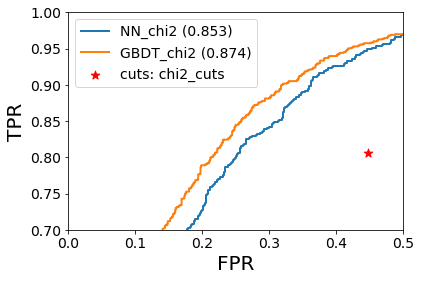

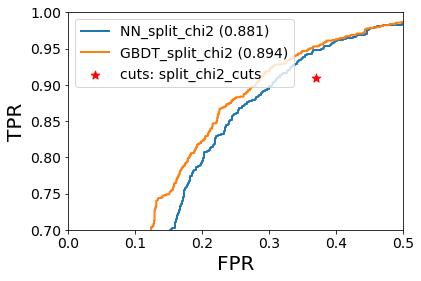

In [11]:
xlims=(0, .5)
ylims=(.7, 1)

for model_set_name in model_set_names:
    NN_pred_name = "NN_{}".format(model_set_name)
    GBDT_pred_name = "GBDT_{}".format(model_set_name)
    cut_pred_name = "{}_cuts".format(model_set_name)
    ndmlplot.plot_rocs(test_ds, [NN_pred_name, GBDT_pred_name], [cut_pred_name], xlims=xlims, ylims=ylims)

### Particle TPR and FPR by Threshold

Plot TPR and FPR for particles of a particular type as the threshold for assigning probablistic values to either genuine or not genuine shifts from zero to one. Make plots for both sets of models to compare performance.

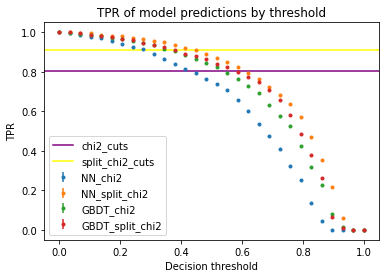

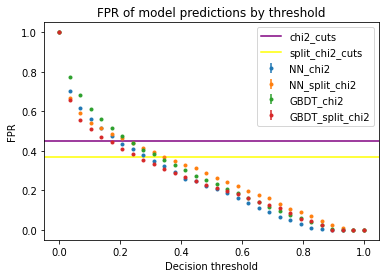

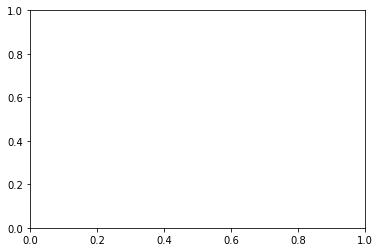

In [12]:
# TPR/FPR vs. decision thresh, overlaid by model/cut prediction.
num_thresholds = 30

for pred_comparison, pred_comp_name in zip(
        [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
        ["TPR", "FPR"]):
    ax = gca()
    for pred_name in test_ds.get_all_prediction_names():
        if "cut" in pred_name:  # cut predictions are not probablistic and so do not vary by threshold
            ax.axhline(pred_comparison(test_ds.get_labels(),
                                       test_ds.get_prediction(pred_name))[0],
                       label=pred_name,
                       color="yellow" if "split" in pred_name else "purple")
        else:
            ax = ndmlplot.plot_pred_comparison_by_threshold(test_ds, pred_name, pred_comparison, 
                                                            thresholds=num_thresholds,
                                                            legend_id=pred_name, ax=ax)
    ax.set_ylabel(pred_comp_name)
    ax.set_title("{} of model predictions by threshold".format(pred_comp_name))
    ax.legend()
    show()
    cla()

### Particle TPR and FPR by Track Property

Plots TPR and FPR for particles of a particular type for binned values of some track property. The aim of this is to get a sense of how model performance depends upon track properties like pT and eta. Makes plots for both sets of models to compare performance.

In [14]:
def overlay_predictions_by_track_property(
    pred_names, model_set_name, pred_comparison, pred_comp_name, binning_prop, bins):
    """Bin a set of predictions by some track property."""
    
    ax = gca()
    for pred_name in pred_names:
        ax = ndmlplot.plot_pred_comparison_by_track_property(
                test_ds, pred_name,
                pred_comparison, binning_prop, bins=bins, threshold=threshold,
                legend_id=pred_name, ax=ax)
    for line in ax.get_lines():
        line.set_linestyle("-")
        line.set_drawstyle("steps-mid")
        line.set_marker("")
    ax.set_ylabel(pred_comp_name)
    ax.set_title("{} of {} model predictions vs. {}; threshold of {}"
                 .format(pred_comp_name, model_set_name, binning_prop, threshold))
    ax.legend()
    show()
    cla()

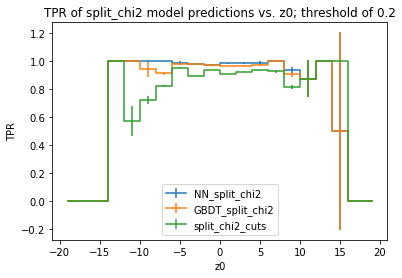

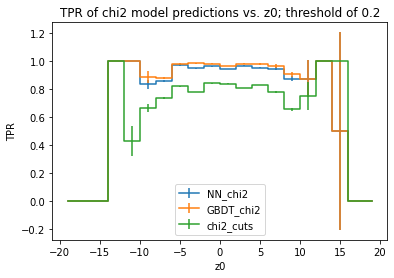

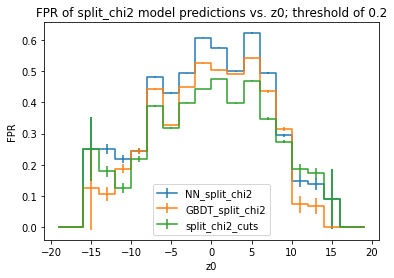

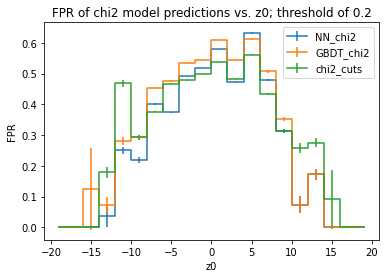

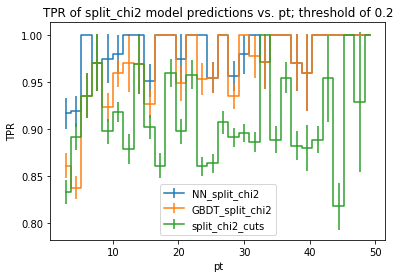

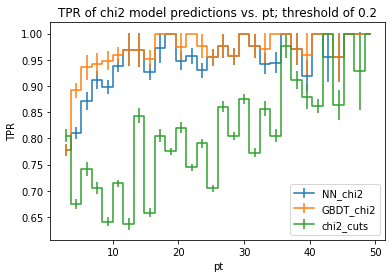

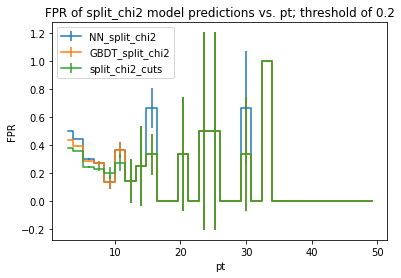

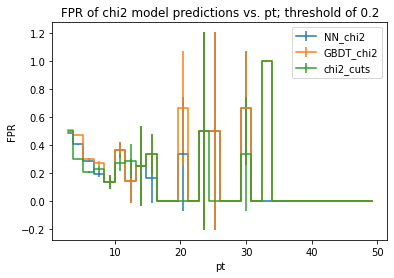

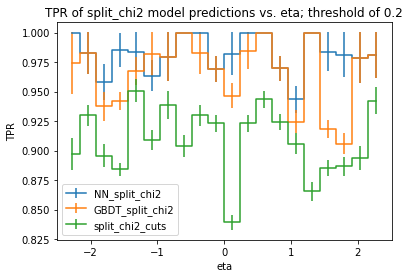

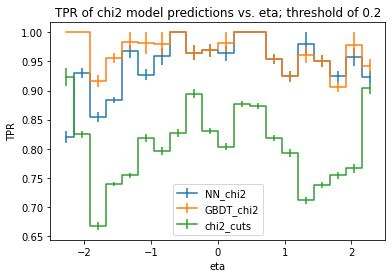

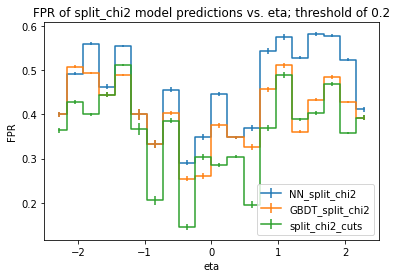

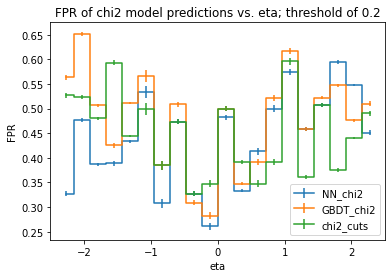

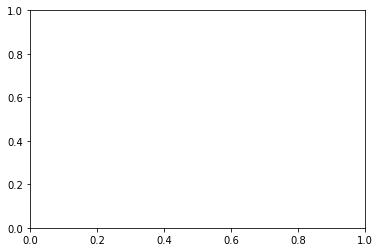

In [17]:
# A dictionary from track properties to bin specifiers
binning_dict = {"z0": (-20, 20, 20), "pt": (2, 50, 30), "eta": (-2.4, 2.4, 20)}
threshold = 0.2
    
# Get names of predictions for each model set
split_chi2_preds = list(filter(lambda pred: "split" in pred, test_ds.get_all_prediction_names()))
chi2_preds = list(filter(lambda pred: "split" not in pred, test_ds.get_all_prediction_names()))

for binning_prop, bins in zip(binning_dict.keys(), binning_dict.values()):  # Iterate through binning props
    for pred_comparison, pred_comp_name in zip(
            [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
            ["TPR", "FPR"]):  # Iterate through prediction measurement types
        overlay_predictions_by_track_property(
            split_chi2_preds, "split_chi2", pred_comparison, pred_comp_name, binning_prop, bins)
        overlay_predictions_by_track_property(
            chi2_preds, "chi2", pred_comparison, pred_comp_name, binning_prop, bins)

## Discussion

The goal of this study was twofold: to see whether a dedicated ML algorithm for electrons would benefit from the addition of a new set of "split chi2" variables: chi2rphi and chi2rz, and to see whether we needed fancy machine learning at all, and whether cuts would do.

As a part of both of these, graphs were made with repect to track properties to make sure that the models or cuts didn't discriminate based on track property.

First question first: **Do models trained on split chi2 variables perform better?**  
Answer: **Yes, a little bit.**

The area under a ROC curve (AUC) can be taken as a general measure of how well an algorithm performs in a predictive binary classification problem, and here the AUC for both models increases by 2-3% when they are allowed to train on chi2rz as opposed to chi2.

This isn't as much as we would expect, but it is something.

Next question: **Do the models perform enough better than cuts that we should use them?**  
Answer: **Yes, if we hold the computational time equal.**

Again with the ROC curve: although the split chi2 cuts are closer to the model curves, the curves still bound the points plotted by the cut sets with and without the split chi2 variables.

While models should reasonably take longer to produce output than a cut set should, this question is heavily specific to application and so has been ignored for this study.

Last question: **Do either set of discriminators heavily discriminate against certain track properties?**  
Answer: **No, at least not for pT, eta, and z0.**

### Future Work

**Hyperparameter optimization**: The hyperparameters for the models were chosen using Claire Savard's (CU Boulder, graduate student) previous work on machine learning for the track-trigger.
However, her studies focused on trkMET cuts, and so her optimized hyperparameters could be different from those for this study.

**Tracklet seed variable**: Another variable indexed by track is the tracklet seed variable, which has its roots in the track-trigger algorithm (see page 16 of [this slideshow](https://wiki.classe.cornell.edu/pub/People/AndersRyd/170629_Tracklet_AWLC.pdf) for more information).
However, how tracklet seed would be used is a tricky question, as it isn't mappable to the real numbers like pT, eta, or a number of missing moules is.
More thought should be put into it.

### Conclusion: The Verdict, In A Sentence

Models are more performant than cuts on discriminating between primary electrons and fake tracks, and both cuts and models using the chi2rz property are more performant than cuts and models using only the chi2 property.
Leaving the question of computational resources and time up to the implementation, **models trained on chi2rz are the best way to discriminate between primary-interaction electrons and fake tracks**.

Further work should be done to optimize model hyperparameters and to make use of tracklet seed.